# Problem 3

This is a image classification problem where we want to classify whether the image was taken either from Wat Po or Wat Prakeaw. This task is very challenging as both are temple which contain many similar objects. However, there are some objects that are unique to one of the places. To solve this problem, I'm going to use Convolutional Neural Network (CNN) to classify the image. I'm build my own CNN model and also use RESNET to leverage the method of transfer learning where there might be some low level feature that might benefit for classification.
<br>
<br>
The temple images were download from google. However, some of the images are not related to the temple, therefore they were removed manually. This might lead to bias of the model, however let's see the model performance.

In [57]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import glob
import os

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import scikitplot as skplt

import cv2
from PIL import Image

## Data Preprocessing

For my own CNN model, I'm going to use image as greyscale to reduce computational time.

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# Get path location
watprakeaw_path = r".\\images\\watprakeaw\\*.jpg"
watprakeaw_files = glob.glob(os.getcwd() + watprakeaw_path)

watpo_path = r".\\images\\wat po\\*.jpg"
watpo_files = glob.glob(os.getcwd() + watpo_path)

In [9]:
df_watpramakew = pd.DataFrame({'temple': watprakeaw_files})
df_watpramakew['label'] = "watpramakew"

In [10]:
df_watpo = pd.DataFrame({'temple': watpo_files})
df_watpo['label'] = "watpo"

Create a dataframe that contain absolute path of all images and its label

In [11]:
df = pd.concat([df_watpramakew, df_watpo])
df = df.reset_index(drop = True)
df = df.fillna(0)

The ground truth labels are not balanced. However, I won't change the class weight to see whehter the model could be able to predict accurately.

In [12]:
df['label'].value_counts()

watpramakew    399
watpo          220
Name: label, dtype: int64

In [13]:
X = pd.DataFrame(df['temple'])
y = pd.DataFrame(df['label'])

Split data into train and test set. I didn't create validate set as Keras ImageDataGenerator class has building validation split. I'm going to use 80% of data for traningset and 15% of the training as validation set. The rest are used as testing set

In [14]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [15]:
# dataframe contain abolute path and label
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [16]:
train

,temple,label
210,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
159,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
86,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
61,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
317,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
...,...,...
259,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
32,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
278,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpramakew
517,D:\Download\Theoretical Exam - Chula UTC AI Ac...,watpo


In this problem, I could train the model by saving all the images into RAM as there aren't many images. However, in the real setting there will be so many images that it cannot fit into the memory. Therefore, I want to do the model training from directory to simulate as a real world setting.

In [17]:
# export to CSV
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

## Image Augmentation

Augmentation allows the model to learn better by augmenting the image. Also, when there aren't enough image, this could enchance the model performance by allowing the model to learn low level features.

In [18]:
# data_augmentation
imgen = ImageDataGenerator(rescale=1./255, 
                           zoom_range=0.1,
                           horizontal_flip=True,
                           rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           validation_split=0.15)

Found 495 validated image filenames belonging to 2 classes.


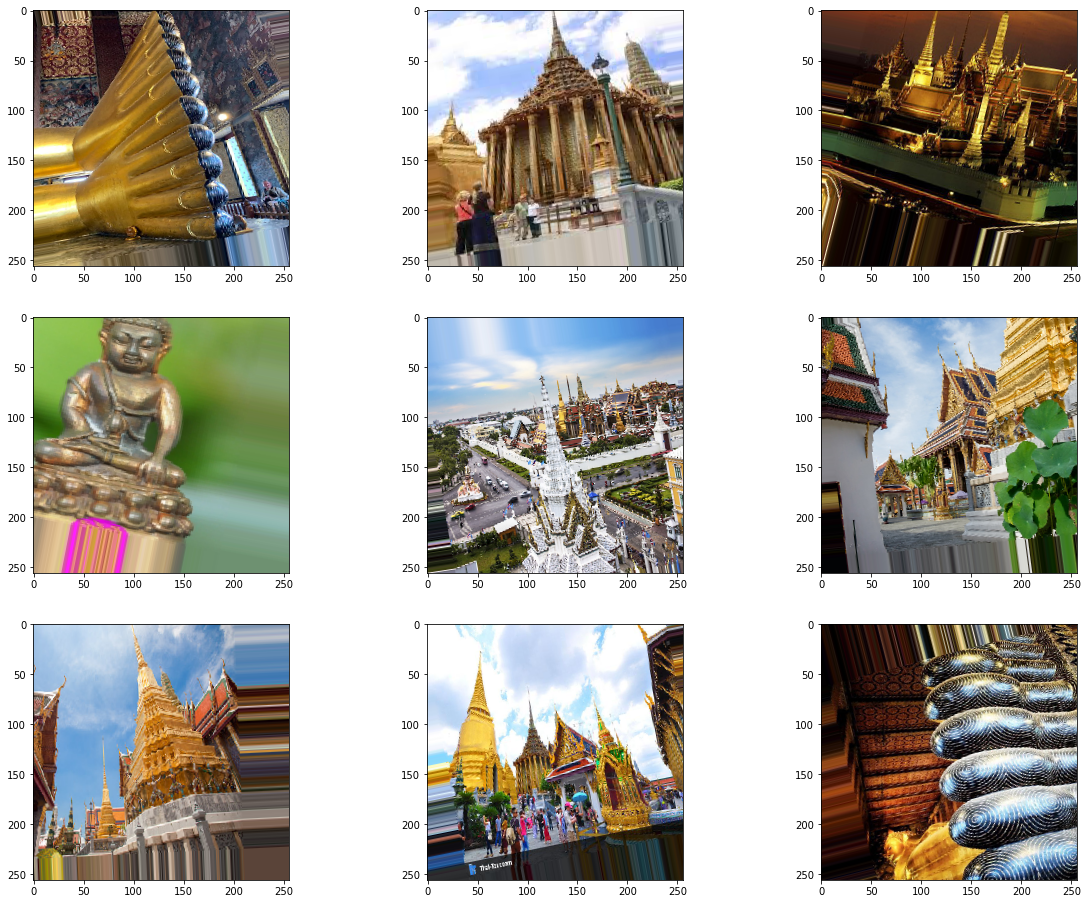

In [19]:
# preview augmented image
i = 0
plt.figure(figsize =(20,16)) 
for batch in imgen.flow_from_dataframe(dataframe=pd.read_csv("train.csv"), x_col='temple', y_col='label', batch_size=1): 
    preview = batch[0].reshape(batch[0].shape[1], batch[0].shape[2], -1)
    plt.subplot (3, 3, i+1) 
    plt.imshow(preview)
    i += 1
    if i > 8:
        break

In [20]:
# dictionary of parameters
hparam = {
    'x_col': 'temple',
    'y_col': 'label',
    'class_mode': 'categorical',
    'target_size': (224,224),
    'seed': 28,
    'color_mode_gery': 'grayscale',
    'color_mode': 'rgb',
    'lr': 0.00001,
    'epochs':200
    
}

In [21]:
# create generators
# color_mode is grey
train_generator = imgen.flow_from_dataframe(dataframe=pd.read_csv("train.csv"), 
                                            x_col= hparam['x_col'], 
                                            y_col=hparam['y_col'],
                                            subset="training",
                                            class_mode=hparam['class_mode'],
                                            target_size = hparam['target_size'],
                                            seed=hparam['seed'],
                                            color_mode = hparam['color_mode_gery']
                                           )

# Get samples
batch = train_generator.next()
data_sample = batch[0]

imgen.fit(data_sample)


valid_generator= imgen.flow_from_dataframe(dataframe=pd.read_csv("train.csv"),
                                            x_col= hparam['x_col'], 
                                            y_col=hparam['y_col'],
                                            subset="validation",
                                            class_mode=hparam['class_mode'],
                                            target_size = hparam['target_size'],
                                            seed=hparam['seed'],
                                           color_mode = hparam['color_mode_gery']
                                           )


test_generator = imgen.flow_from_dataframe(dataframe=pd.read_csv("test.csv"),
                                           x_col= hparam['x_col'], 
                                           y_col=hparam['y_col'],
                                           target_size = hparam['target_size'],
                                           class_mode=hparam['class_mode'],
                                           seed=hparam['seed'],
                                           color_mode = hparam['color_mode_gery']
                                          )


Found 421 validated image filenames belonging to 2 classes.
Found 74 validated image filenames belonging to 2 classes.
Found 124 validated image filenames belonging to 2 classes.


I have create my own CNN where the deeper the layer, the increase in nodes. The reason behind this is I expect the model to high level pattern that might be good classification features. Also, I applied dropout after flatten layer and before output layer to prevent overfitting of the model

In [73]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer = optimizers.Adam(lr = hparam['lr']),loss="categorical_crossentropy",metrics=["accuracy"])


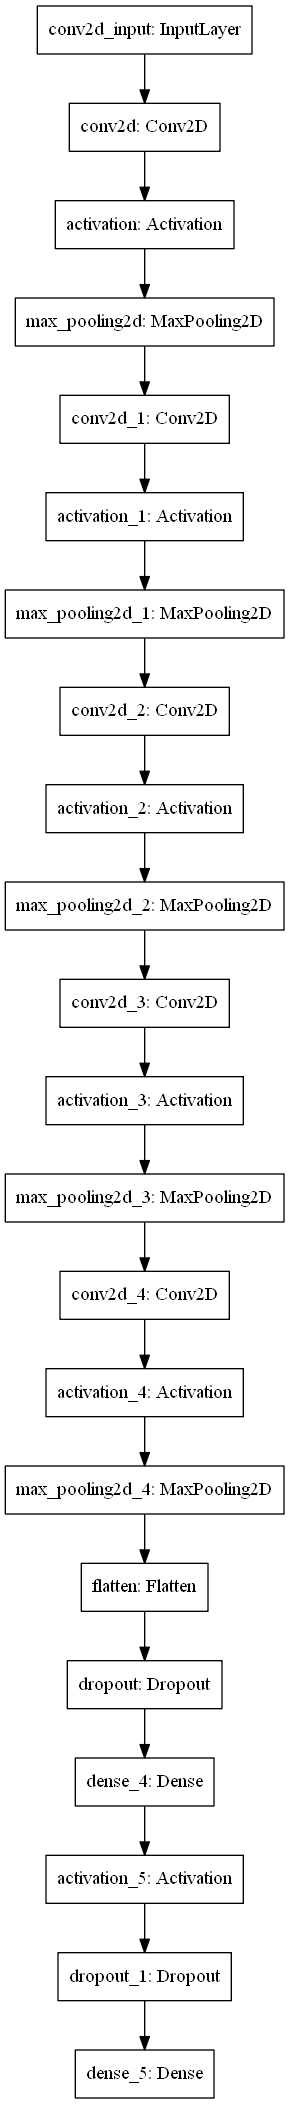

In [74]:
# visualize the model architecture
plot_model(model)

In [75]:
# see the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

I used the model checkpoint to save the best model and decrease learning rate while training. The latter facilitate in finding the global optimum. The dont use earlystop as I want to run until the end of epochs and save the best model with lowest validation loss.

In [19]:
# calcualte step size for train, validate and test set
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

set_random_seed = 28

# save the model that has the lowest validation loss
mcp_save = ModelCheckpoint(r'./model/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# reduce the learning rate after 10 rounds with no better validation loss.
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
# earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=hparam['epochs'],
                    callbacks=[mcp_save, reduce_lr_loss]
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
13/13 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5296
Epoch 00001: val_loss improved from inf to 0.68645, saving model to ./model/best_model.hdf5
13/13 [==============================] - 13s 1s/step - loss: 0.6924 - accuracy: 0.5296 - val_loss: 0.6865 - val_accuracy: 0.6562 - lr: 1.0000e-05
Epoch 2/200
12/13 [==========================>...] - ETA: 0s - loss: 0.6839 - accuracy: 0.6484
Epoch 00002: val_loss improved from 0.68645 to 0.67780, saving model to ./model/best_model.hdf5
13/13 [==============================] - 6s 499ms/step - loss: 0.6837 - accuracy: 0.6504 - val_loss: 0.6778 - val_accuracy: 0.6562 - lr: 1.0000e-05
Epoch 3/200
12/13 [==========================>...] - ETA: 0s - loss: 0.6780 - accuracy: 0.6380
Epoch 00003: val_loss improved from 0.67780 to 0.66950, saving model to ./model/best_model.hdf5
13/13 [==============================] - 6s 490ms/step - loss

Epoch 27/200
13/13 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.6170
Epoch 00027: val_loss did not improve from 0.62373
13/13 [==============================] - 6s 481ms/step - loss: 0.6571 - accuracy: 0.6170 - val_loss: 0.6358 - val_accuracy: 0.6719 - lr: 1.0000e-06
Epoch 28/200
13/13 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.6272
Epoch 00028: val_loss did not improve from 0.62373

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
13/13 [==============================] - 6s 478ms/step - loss: 0.6501 - accuracy: 0.6272 - val_loss: 0.6305 - val_accuracy: 0.6719 - lr: 1.0000e-06
Epoch 29/200
13/13 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6298
Epoch 00029: val_loss did not improve from 0.62373
13/13 [==============================] - 6s 471ms/step - loss: 0.6513 - accuracy: 0.6298 - val_loss: 0.6252 - val_accuracy: 0.6875 - lr: 1.0000e-07
Epoch 30/200
13/13 [==============

13/13 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.6375
Epoch 00081: val_loss improved from 0.61560 to 0.59878, saving model to ./model/best_model.hdf5
13/13 [==============================] - 7s 503ms/step - loss: 0.6473 - accuracy: 0.6375 - val_loss: 0.5988 - val_accuracy: 0.7188 - lr: 1.0000e-10
Epoch 82/200
13/13 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.6375
Epoch 00082: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 469ms/step - loss: 0.6479 - accuracy: 0.6375 - val_loss: 0.6750 - val_accuracy: 0.6094 - lr: 1.0000e-10
Epoch 83/200
13/13 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.6298
Epoch 00083: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 451ms/step - loss: 0.6484 - accuracy: 0.6298 - val_loss: 0.6294 - val_accuracy: 0.6719 - lr: 1.0000e-10
Epoch 84/200
13/13 [==============================] - ETA: 0s - loss: 0.6528 - accu

Epoch 135/200
13/13 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.6221
Epoch 00135: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 460ms/step - loss: 0.6557 - accuracy: 0.6221 - val_loss: 0.6256 - val_accuracy: 0.6875 - lr: 1.0000e-15
Epoch 136/200
13/13 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.6298
Epoch 00136: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 450ms/step - loss: 0.6500 - accuracy: 0.6298 - val_loss: 0.6132 - val_accuracy: 0.7031 - lr: 1.0000e-15
Epoch 137/200
13/13 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6375
Epoch 00137: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 443ms/step - loss: 0.6494 - accuracy: 0.6375 - val_loss: 0.6429 - val_accuracy: 0.6562 - lr: 1.0000e-15
Epoch 138/200
13/13 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.6247
Epoch 00138: va

Epoch 162/200
13/13 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.6324
Epoch 00162: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 460ms/step - loss: 0.6513 - accuracy: 0.6324 - val_loss: 0.6346 - val_accuracy: 0.6719 - lr: 1.0000e-18
Epoch 163/200
13/13 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.6401
Epoch 00163: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 432ms/step - loss: 0.6477 - accuracy: 0.6401 - val_loss: 0.6656 - val_accuracy: 0.6250 - lr: 1.0000e-18
Epoch 164/200
13/13 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.6350
Epoch 00164: val_loss did not improve from 0.59878
13/13 [==============================] - 6s 471ms/step - loss: 0.6467 - accuracy: 0.6350 - val_loss: 0.6472 - val_accuracy: 0.6562 - lr: 1.0000e-18
Epoch 165/200
13/13 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6375
Epoch 00165: va

Epoch 189/200
13/13 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.6272
Epoch 00189: val_loss did not improve from 0.59626
13/13 [==============================] - 6s 478ms/step - loss: 0.6553 - accuracy: 0.6272 - val_loss: 0.6374 - val_accuracy: 0.6719 - lr: 1.0000e-20
Epoch 190/200
13/13 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.6427
Epoch 00190: val_loss did not improve from 0.59626
13/13 [==============================] - 6s 473ms/step - loss: 0.6459 - accuracy: 0.6427 - val_loss: 0.6513 - val_accuracy: 0.6406 - lr: 1.0000e-20
Epoch 191/200
13/13 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6298
Epoch 00191: val_loss did not improve from 0.59626
13/13 [==============================] - 6s 471ms/step - loss: 0.6505 - accuracy: 0.6298 - val_loss: 0.6268 - val_accuracy: 0.6875 - lr: 1.0000e-20
Epoch 192/200
13/13 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.6350
Epoch 00192: va

According to the pictures below, the accuracy in both train and validation set didn't appear to improve after several epochs. This might be because the model has too high learning rate and lead to the model stuck in the local optimum. Another reason is the preprocessing steps wasn't good enough for the model to distinguish between two images. Also, one major reason is that the images used in the training and validation set are not good represation of the temples. 

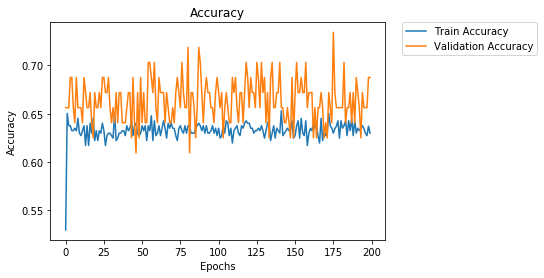

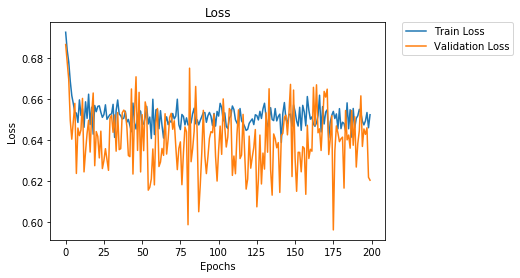

In [20]:
# Visualize train and validation accuracy and loss

epoch_list = list(range(len(model.history.history['accuracy'])))
plt.plot(epoch_list, model.history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_list, model.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

epoch_list = list(range(len(model.history.history['loss'])))
plt.plot(epoch_list, model.history.history['loss'], label='Train Loss')
plt.plot(epoch_list, model.history.history['val_loss'], label='Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [20]:
train_loss, train_accuracy = model.evaluate_generator(train_generator)
print(f"The training loss is {round(train_loss,2)} and training accuracy is {round(train_accuracy,2)}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
The training loss is 0.59 and training accuracy is 0.65


## Transfer Learning

For transfer learning, I will use RESNET architecture with weight from imagenet. RESNET has an advantage of allow the information to move through the residual blocks which generalize the model performance. The imagenet weight is useful as this weight is trained from many pictures which could lead to model to learn better because of low level feature. The output layer of the RESNET is replaced by our own classification output layer.

In [72]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [73]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [74]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

I start with freezing all layers, only layers with conv5 and below will be trainable. This leverage the RESNET weight that might have good pattern to distinguish between two temples.

In [75]:
i = 0
for layer in model.layers:
    if layer.name == 'conv5_block3_1_conv':
        break
    else:
        i += 1

print("model.layers[i].name is in layer", f"{i}")

model.layers[i].name is in layer 165


In [76]:
for layer in model.layers[:i]:
   layer.trainable = False
for layer in model.layers[i:]:
   layer.trainable = True

The color mode will change from grayscale into rgb as the RESNET architecture is build from coloured images.

In [24]:
# Use preprocess methodology the same way as RESNET
imgen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)

In [25]:
# create generator with rgb colour
train_generator = imgen.flow_from_dataframe(dataframe=pd.read_csv("train.csv"), 
                                            x_col= hparam['x_col'], 
                                            y_col=hparam['y_col'],
                                            subset="training",
                                            class_mode=hparam['class_mode'],
                                            target_size = hparam['target_size'],
                                            seed=hparam['seed'],
                                            color_mode = hparam['color_mode']
                                           )

# Get samples
batch = train_generator.next()
data_sample = batch[0]
imgen.fit(data_sample)

valid_generator= imgen.flow_from_dataframe(dataframe=pd.read_csv("train.csv"),
                                            x_col= hparam['x_col'], 
                                            y_col=hparam['y_col'],
                                            subset="validation",
                                            class_mode=hparam['class_mode'],
                                            target_size = hparam['target_size'],
                                            seed=hparam['seed'],
                                           color_mode = hparam['color_mode']
                                           )

test_generator = imgen.flow_from_dataframe(dataframe=pd.read_csv("test.csv"),
                                           x_col= hparam['x_col'], 
                                           y_col=hparam['y_col'],
                                           target_size = hparam['target_size'],
                                           class_mode=hparam['class_mode'],
                                           seed=hparam['seed'],
                                           color_mode = hparam['color_mode']
                                          )

Found 421 validated image filenames belonging to 2 classes.
Found 74 validated image filenames belonging to 2 classes.
Found 124 validated image filenames belonging to 2 classes.


In [26]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

set_random_seed = 28

model.compile(optimizer = optimizers.Adam(lr = hparam['lr']),loss="categorical_crossentropy",metrics=["accuracy"])

# save best model
mcp_save = ModelCheckpoint(r'./model/resnet_best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# reduce learning rate while training
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, epsilon=1e-4, mode='min')
#earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=hparam['epochs'],
                    callbacks=[mcp_save, reduce_lr_loss]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200


KeyboardInterrupt: 

The image belows show that the model overfit. We reduce the overfit by adding dropout layer into model. The model that show sign of less overfit is when value the accuracy and loss of the train and validation set are similar.

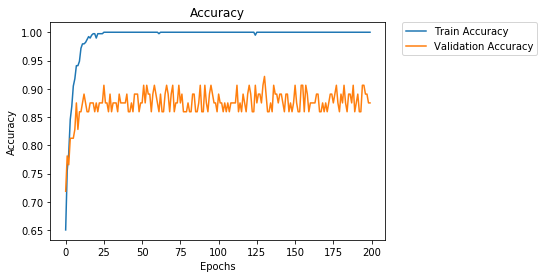

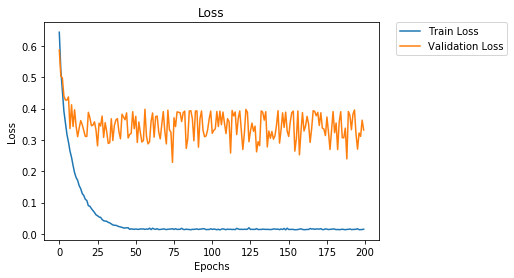

In [80]:
# Visualize train and validation accuracy and loss

epoch_list = list(range(len(model.history.history['accuracy'])))
plt.plot(epoch_list, model.history.history['accuracy'], label='Train Accuracy')
plt.plot(epoch_list, model.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

epoch_list = list(range(len(model.history.history['loss'])))
plt.plot(epoch_list, model.history.history['loss'], label='Train Loss')
plt.plot(epoch_list, model.history.history['val_loss'], label='Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [81]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"The training loss is {round(train_loss,2)} and training accuracy is {round(train_accuracy,2)}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
The training loss is 0.01 and training accuracy is 1.0


In [82]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)
print(f"The valid loss is {round(valid_loss,2)} and valid accuracy is {round(valid_accuracy,2)}")

3/3 [==============================] - 0s 130ms/step - loss: 0.3424 - accuracy: 0.8784
The valid loss is 0.34 and valid accuracy is 0.88


## Model Evaluation

In [22]:
# Load Model
model = load_model(r"./model/resnet_best_model.h5")

In [27]:
# result from training set
yhat_prob = model.predict_generator(train_generator)
# Get classes by max element in np (as a list)
yhat = list(np.argmax(yhat_prob, axis=1))
# Get filenames (set shuffle=false in generator is important)
filenames = train_generator.filenames
# dictionary of classes
train_generator.class_indices

{'watpo': 0, 'watpramakew': 1}

In [28]:
# get y_train
y_train = train_generator.classes

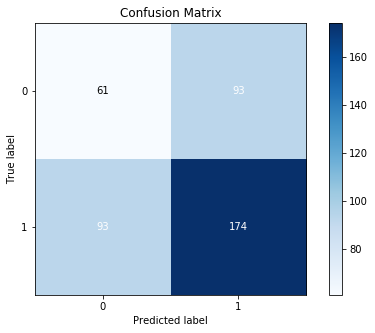

In [29]:
skplt.metrics.plot_confusion_matrix(train_generator.classes, yhat, normalize=False, figsize=(8,5))

In [30]:
print(classification_report(y_train, yhat))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40       154
           1       0.65      0.65      0.65       267

    accuracy                           0.56       421
   macro avg       0.52      0.52      0.52       421
weighted avg       0.56      0.56      0.56       421



In [31]:
# result from validation set
yhat_prob_validate = model.predict_generator(valid_generator)
# Get classes by max element in np (as a list)
yhat_validate = list(np.argmax(yhat_prob_validate, axis=1))
# get y_train
y_validate = valid_generator.classes

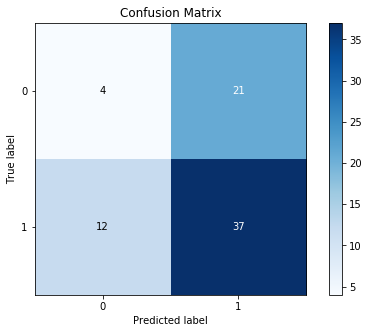

In [32]:
skplt.metrics.plot_confusion_matrix(y_validate, yhat_validate, normalize=False, figsize=(8,5))

In [33]:
print(classification_report(y_validate, yhat_validate))

              precision    recall  f1-score   support

           0       0.25      0.16      0.20        25
           1       0.64      0.76      0.69        49

    accuracy                           0.55        74
   macro avg       0.44      0.46      0.44        74
weighted avg       0.51      0.55      0.52        74



In [104]:
# result from test set
yhat_prob_test = model.predict(test_generator)
# Get classes by max element in np (as a list)
yhat_test = list(np.argmax(yhat_prob_test, axis=1))
# get y_train
y_test = test_generator.classes

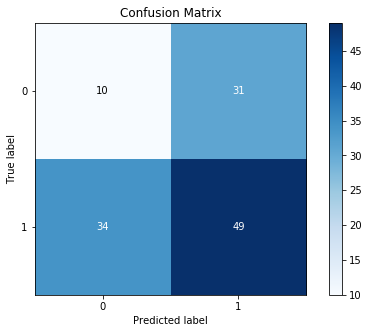

In [35]:
skplt.metrics.plot_confusion_matrix(y_test, yhat_test, normalize=False, figsize=(8,5))

In [36]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.23      0.24      0.24        41
           1       0.61      0.59      0.60        83

    accuracy                           0.48       124
   macro avg       0.42      0.42      0.42       124
weighted avg       0.49      0.48      0.48       124



The graphs below show that the model prediciton is as good as coin flip.

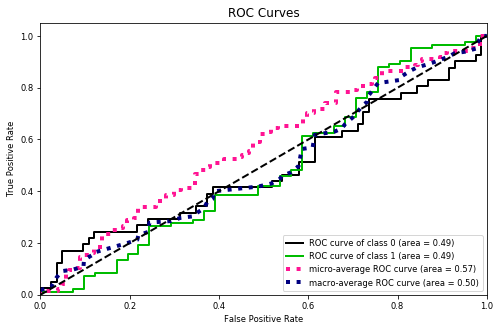

In [106]:
skplt.metrics.plot_roc(test_generator.classes, yhat_prob_test, text_fontsize = 'small', figsize = (8,5))

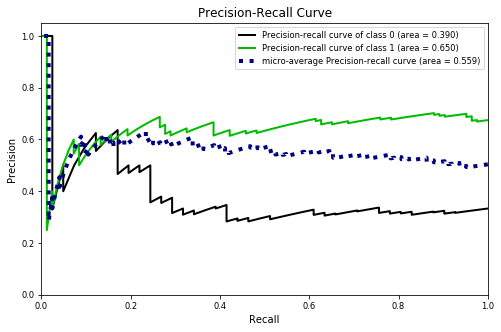

In [107]:
skplt.metrics.plot_precision_recall(test_generator.classes, yhat_prob_test, text_fontsize = 'small', figsize = (8,5))

In [90]:
# inverse key value dictionary of the ground trith
train_generator.class_indices

class_dict = {}
for k,v in train_generator.class_indices.items():
    class_dict[v] = k
    
class_dict

{0: 'watpo', 1: 'watpramakew'}

Let see the incorrectly classiied images

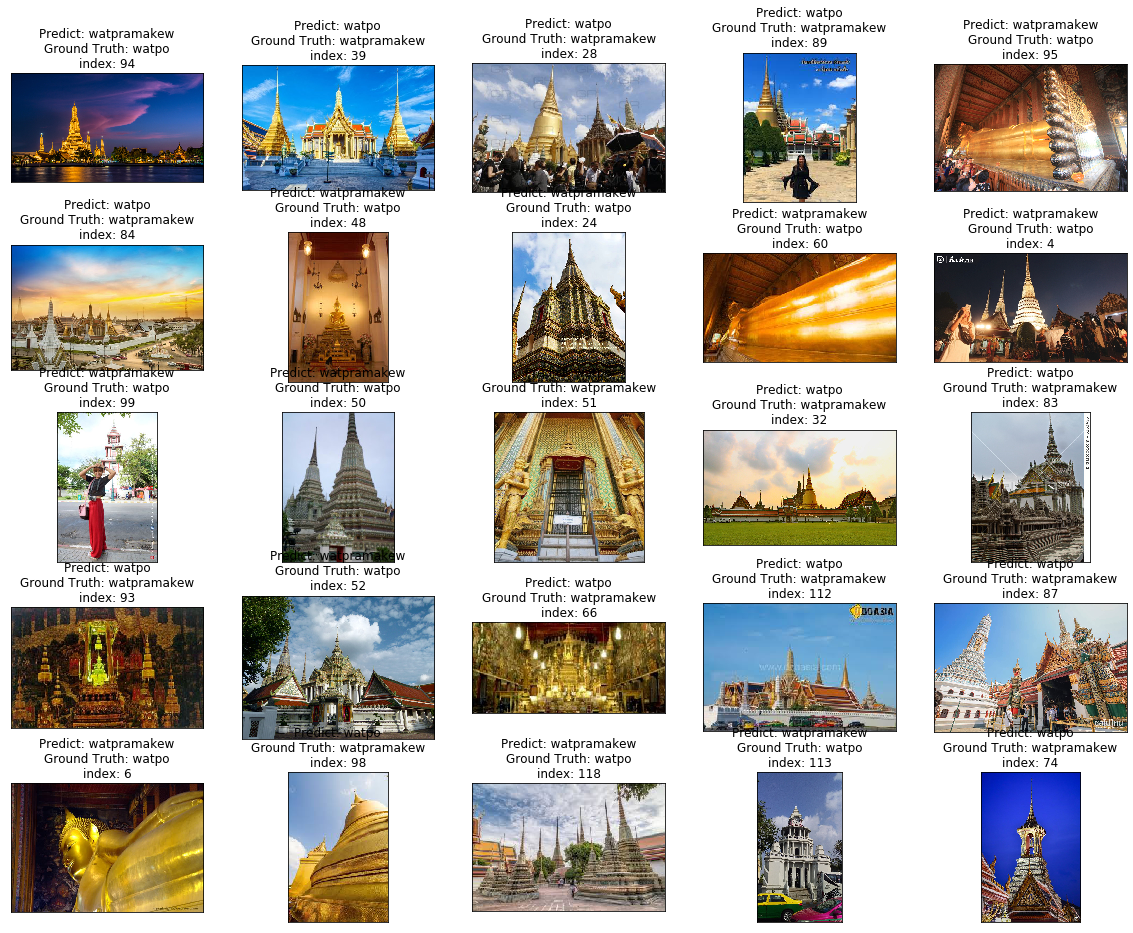

In [99]:
# visualize which images are incorrectly predicted

incorrect_imagenumbers = y_test[(y_test != yhat_test_df)].index
nincorrect = len(incorrect_imagenumbers)
nsample = 25
samples = np.random.choice(incorrect_imagenumbers, min(nsample, nincorrect), replace=False) 

plt.figure(figsize =(20,16)) 
for i,sample in enumerate(samples):  
    #print(i,sample)
    writer = files[sample]
    plt.subplot (5, 5, i+1)
    cv2.imread(writer)
    plt.imshow(Image.open(writer))
    plt.title('Predict: ' + class_dict[yhat_test[sample]] + '\n' + 
              'Ground Truth: ' + class_dict[y_test[sample]] + '\n'
             'index: '+  str(sample))
    plt.xticks([]) 
    plt.yticks([])

## Dicussion

According to the images that are incorrectly predicted, there are many images that has object that unique represent the temple. This indicate that the model still cannot find good pattern that help in the image classification. Also, the model appears the have overfitting problem so I could lower the overfiting problem by adding regularization such as dropout layer. Moreover, we could make the model more interpretable by using visualization method such as Grad-Cam. This could help in better model development as we know where the model give most attention on.